In [77]:
from numpy import zeros

from sklearn import preprocessing, pipeline, svm
import cogent
from cogent import LoadSeqs, DNA, LoadTree
from cogent.draw.dendrogram import UnrootedDendrogram
from rpy2.robjects.packages import importr
import seaborn as sns
from pandas import DataFrame

In [11]:
%matplotlib inline

In [2]:
%load_ext rpy2.ipython
peptides = importr('Peptides')
%R -o pepdata data(pepdata)

array(['pepdata'],
      dtype='|S7')

In [3]:
factors = [peptides.charge,
           peptides.hydrophobicity,
           peptides.hmoment,
           peptides.instaIndex]
X = [[f(s)[0] for f in factors]
     for s in pepdata.sequence]
y = map(int, pepdata.group)

In [4]:
classifier = pipeline.Pipeline(
    steps=[('scale', preprocessing.StandardScaler()),
           ('svm', svm.LinearSVC())])
classifier.fit(X, y)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [5]:
def is_antimicrobial(seq, classifier=classifier, length=22, factors=factors):
    seq = seq.replace('-', '')
    if len(seq) < length:
        return False
    x = [f(seq)[0] for f in factors]
    return bool(classifier.predict([x])[0])

In [6]:
joint = LoadSeqs('../results/joint.fasta', moltype=DNA)
joint = joint.getTranslation().todict().values()

In [39]:
minlen = 3
jointlen = len(joint[0])
maxmaxlen = 50
antimicrobial_count = zeros((maxmaxlen - minlen, jointlen),
                            dtype=int)
for start in range(jointlen):
    for maxlen in range(minlen, min(maxmaxlen, jointlen - start)):
        for seq in joint:
            antimicrobial_count[maxlen - minlen, start] += \
                is_antimicrobial(seq[start:start+maxlen], length=minlen)

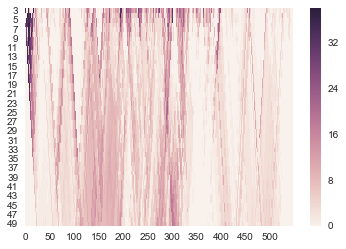

In [63]:
centrered_count = []
for i, row in enumerate(antimicrobial_count[:maxmaxlen-minlen]):
    pad = int(i/2)
    centrered_count.append([0]*pad + list(row[:jointlen-pad]))
df = DataFrame(centrered_count,
               index=range(minlen, maxmaxlen))
ax = sns.heatmap(df, yticklabels=2, xticklabels=50);

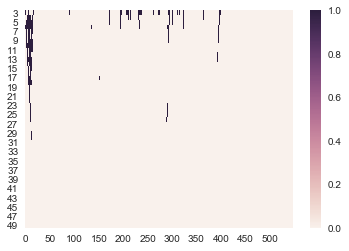

In [64]:
sns.heatmap(df > 20, yticklabels=2, xticklabels=50);

In [67]:
for start in range(2, jointlen):
    for maxlen in range(21, jointlen - start):
        if antimicrobial_count[maxlen - minlen, start] > 20:
            print start, maxlen, antimicrobial_count[maxlen - minlen, start]

279 26 22.0
279 27 22.0
280 25 22.0
280 26 22.0
281 24 21.0
281 25 21.0
282 23 22.0
282 24 22.0
283 23 21.0
284 22 21.0


In [90]:
tree = LoadTree('../results/cnfgtr.nwk')
joint = LoadSeqs('../results/joint.fasta', moltype=DNA)
joint = joint.getTranslation()
joint_peptide = joint[279:279+27]

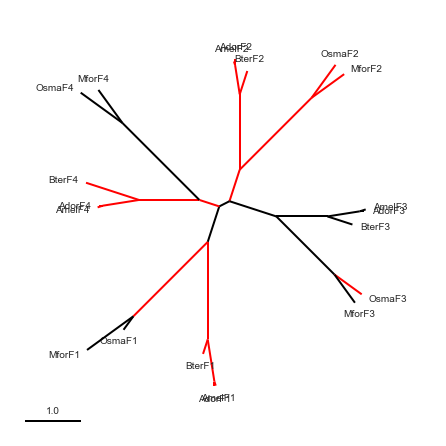

In [109]:
amps = []
for label, node in tree.getNodesDict().items():
    seq = str(joint_peptide.getGappedSeq(label))
    node.params['AMP'] = is_antimicrobial(seq)
    if node.params['AMP']:
        amps.append(label)
dend = UnrootedDendrogram(tree)
fig = dend.makeFigure(height=6, width=6, shade_param='AMP',
                      max_value=1.0, stroke_width=2)
fig.savefig('../results/ugly_tree.pdf')
amps = joint_peptide.takeSeqs(amps).todict()
amps = LoadSeqs(data=amps)
amps.degap().writeToFile('../results/amps.fasta')

In [110]:
!cat ../results/amps.fasta

>MforF2
LAATAAKAKESAMKSLSAAQAAAKA
>twoBeesF2
AQVKAAIARKSAANFLAKAQVAAAA
>BterF2
AQVKAELAKKAAAGFLAKARLAASA
>BterF1
AKLKAAAAASAAAAASAAAEAALKA
>twoBeesF1
AKVKAIAAANLAAAASAAAEAALKA
>twoBeesF4
AQAKTAAAAKAAEIALKVAEIAVKA
>BterF4
AQAKAAAAAKATQLALKVAETAVKT
>OsmaF2
LSASAGKAQQSATRALQAARAAAKA
>OsmaF3
IAKAASGQGGTRAAVDAAAAAAAAAAL
>rootF4
AEAKAAAAKKAAATALAVAEAAVTA
>rootF2
AEAKAAKAKKSAASSLAAAQAAATA
>threeBeesF2
AQVKAAIAKKSAASFLAKAQVAATA
>threeBeesF1
AKVKAAAAANSAAAASAAAEAALKA
>threeBeesF4
AQAKAAAAAKAAEIALKVAETAVKA
>AmelF1
AKAKAIAAANLAAEASVAAEAALKA
>AmelF2
AQVKAAIARKSAANFLAKAQIAAAA
>AmelF4
AQAKTAAAAKAAEIALKVAEIAVKA
>AdorF1
AKVKAIAAANLAAAASAAAEAALKA
>AdorF2
AQVKAAIARKSAANFLAKAQVAAAT
>AdorF4
AQAKTAAAAKAAEIALKVADIAVKA
>twoAntsF2
LGASAAKAKESATRSLRAAQAAAKA
>twoAntsF1
AAEKANKALASTRAASAATQRAVAA


In [111]:
all_peptides = joint_peptide.todict()
all_peptides = LoadSeqs(data=all_peptides)
all_peptides.degap().writeToFile('../results/peptides.fasta')

In [112]:
!cat ../results/peptides.fasta

>MforF2
LAATAAKAKESAMKSLSAAQAAAKA
>MforF3
IAEASALNNEAAVNAAAAAAAASAL
>MforF1
AARMMEKALAATQDANAAAQQAMAA
>MforF4
AEAKANAGREAAAAALAIAEAAVAI
>twoBeesF2
AQVKAAIARKSAANFLAKAQVAAAA
>BterF2
AQVKAELAKKAAAGFLAKARLAASA
>BterF1
AKLKAAAAASAAAAASAAAEAALKA
>twoBeesF1
AKVKAIAAANLAAAASAAAEAALKA
>twoBeesF4
AQAKTAAAAKAAEIALKVAEIAVKA
>BterF4
AQAKAAAAAKATQLALKVAETAVKT
>OsmaF1
AAEQANKALALSRAASAATQRAVAA
>OsmaF2
LSASAGKAQQSATRALQAARAAAKA
>OsmaF3
IAKAASGQGGTRAAVDAAAAAAAAAAL
>OsmaF4
AEAKANAAQEAGASALAIAQAALNI
>rootF4
AEAKAAAAKKAAATALAVAEAAVTA
>rootF1
AEAKAAEAKKSAAAASAAAEAAVTA
>rootF2
AEAKAAKAKKSAASSLAAAQAAATA
>rootF3
AEEDAAETKRSAATAVAAAAAAAAV
>BterF3
AEQSAAQSKWSAALAAQTAAAAAAI
>twoBeesF3
QSQDAEQTKWNAKSALEASAAAAAA
>threeBeesF2
AQVKAAIAKKSAASFLAKAQVAATA
>threeBeesF3
AEQDAAQTKWSAASAVEAAAAAAAV
>threeBeesF1
AKVKAAAAANSAAAASAAAEAALKA
>threeBeesF4
AQAKAAAAAKAAEIALKVAETAVKA
>AmelF1
AKAKAIAAANLAAEASVAAEAALKA
>rootF1F4
AEAKAAEAKKSAATALAAAEAAVTA
>AmelF3
QLQDAERTKWSANAALEVSAAAAAA
>AmelF2
AQVKAAIARKSAANFLAKAQIAAAA
>AmelF4
AQAK

In [125]:
joint_peptide = joint[144:144+59]

Found 9 AMPs


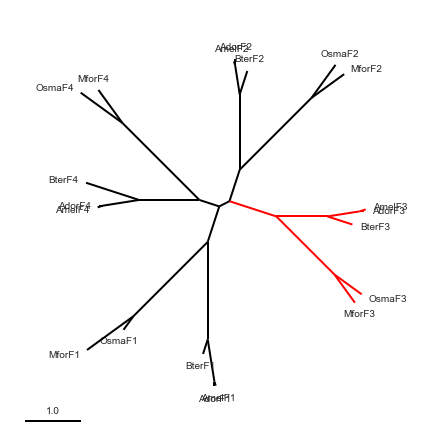

In [128]:
amps = []
for label, node in tree.getNodesDict().items():
    seq = str(joint_peptide.getGappedSeq(label))
    node.params['AMP'] = is_antimicrobial(seq, length=3)
    if node.params['AMP']:
        amps.append(label)
dend = UnrootedDendrogram(tree)
fig = dend.makeFigure(height=6, width=6, shade_param='AMP',
                      max_value=1.0, stroke_width=2)
fig.savefig('../results/tara_tree.pdf')
print 'Found', len(amps), 'AMPs'
amps = joint_peptide.takeSeqs(amps).todict()
amps = LoadSeqs(data=amps)
amps.degap().writeToFile('../results/tara_amps.fasta')

In [127]:
!cat ../results/tara_amps.fasta

>BterF3
STKATAAAEAKASAKVKASALALAEAFLRASAAFAAASAKAAAAVKEA
>twoBeesF3
KIKASAGADAKASAVVKASALALAEAYLRASALSAAASAKAAAALKNA
>AdorF3
KIKASAGADAKTSAVVKASALALAEAYLRASALSAAASAKAAAALKNA
>threeBeesF3
KTKATAAADAKASAKVKASALALAEAYLRASAASAAASAKAAAAVKEA
>OsmaF3
KAQASAQSSAEALAIIKKIVALLISAYVRAAEAAARASAEALATVRAA
>twoAntsF3
KAEASAAAAAEALAMIKKIAMALIRAYVRAAEASAQASAEALATVRAA
>MforF3
RAEANAAAAAEALAMIKKIAMARSSAYVQAAWASAQASADALASARVA
>AmelF3
KIKTSASVNAKAAAVVKASALALAEAYLRASALSAAASAKAAAALKNA
>rootF3
KAKAIAAAAAKASAKVKTVAMALAKAYVRAAAASAAASAKAVATVKEA


In [135]:
amelF3 = joint.getGappedSeq('AmelF3')
print str(amelF3).find('RASALSAAASAKAAAALKNAQQAQLNAQEKSLAALKAQS')
print len('RASALSAAASAKAAAALKNAQQAQLNAQEKSLAALKAQS')

183
39


In [136]:
joint_peptide = joint[183:183+39]

Found 8 AMPs


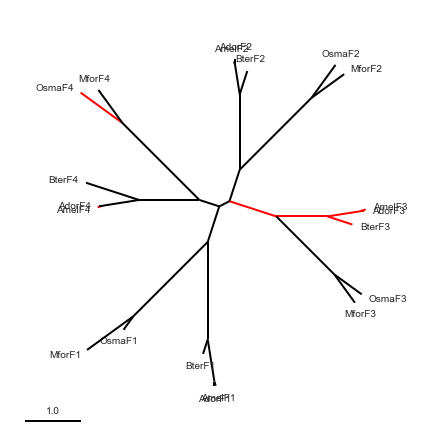

In [137]:
amps = []
for label, node in tree.getNodesDict().items():
    seq = str(joint_peptide.getGappedSeq(label))
    node.params['AMP'] = is_antimicrobial(seq, length=3)
    if node.params['AMP']:
        amps.append(label)
dend = UnrootedDendrogram(tree)
fig = dend.makeFigure(height=6, width=6, shade_param='AMP',
                      max_value=1.0, stroke_width=2)
fig.savefig('../results/flocculator_tree.pdf')
print 'Found', len(amps), 'AMPs'
amps = joint_peptide.takeSeqs(amps).todict()
amps = LoadSeqs(data=amps)
amps.degap().writeToFile('../results/flocculator_amps.fasta')

In [138]:
!cat ../results/flocculator_amps.fasta

>BterF3
RASAAFAAASAKAAAAVKEATQAQLLAQEKALIALKTQS
>twoBeesF3
RASALSAAASAKAAAALKNAQQAQLIAQEKALAALKAQS
>AdorF3
RASALSAAASAKAAAALKNAQQAQLVAQEKALAALKAQS
>threeBeesF3
RASAASAAASAKAAAAVKEATQAQLIAQEKALAALKAQS
>OsmaF4
KSCALAAKSTAQAVALVEKVARAEVDLAESARKATRLSA
>AmelF3
RASALSAAASAKAAAALKNAQQAQLNAQEKSLAALKAQS
>AmelF4
NAAIGASELTNKVAALVAGATGAQARATAASSSALKASL
>rootF3
RAAAASAAASAKAVATVKEATQAQSIAEAKAIAASKALS
